## Base code

In [19]:
import os
import tensorflow as tf
import zipfile
import pandas as pd


In [23]:
# data_path = r"C:\pastaImagensMangas"
data_path = "MangoLeaf"
img_size = (224,224)
batch_size = 32
mode = "rgb"
epochs = 50

In [24]:
import pandas as pd

def df_maker(path):
    file_paths = []
    labels = []

    folds = os.listdir(path)
    for fold in folds:
        fold_path = os.path.join(path,fold)
        file_list = os.listdir(fold_path)
        for file in file_list:
            file_path = os.path.join(fold_path,file)
            file_paths.append(file_path)
            labels.append(fold)


    file_series = pd.Series(file_paths,name="file_paths")
    label_series = pd.Series(labels,name="labels")

    df = pd.concat([file_series,label_series],axis=1)
    return df

In [25]:
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator

df = df_maker(data_path)

train_df,test_val_df= train_test_split(df ,train_size= 0.8, shuffle= True, random_state= 7, stratify=df["labels"])

test_df,val_df= train_test_split(test_val_df ,train_size= 0.5, shuffle= True, random_state= 7, stratify=test_val_df["labels"])

train_datagen = ImageDataGenerator()
test_datagen = ImageDataGenerator()
val_datagen = ImageDataGenerator()

train_data = train_datagen.flow_from_dataframe(
    train_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)
test_data = test_datagen.flow_from_dataframe(
    test_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=False,
)
val_data = val_datagen.flow_from_dataframe(
    val_df,
    x_col = "file_paths",
    y_col = "labels",
    target_size=img_size,
    color_mode= mode,
    class_mode='categorical',
    batch_size=batch_size,
    shuffle=True,
)

Found 3200 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.
Found 400 validated image filenames belonging to 8 classes.


In [26]:
g_dict = train_data.class_indices      # defines dictionary {'class': index}
classes = list(g_dict.keys())       # defines list of dictionary's kays (classes), classes names : string
images, labels = next(train_data)      # get a batch size samples from the generator
# # difference between next iterator and for iterator

## Compress and evaluate models

In [ ]:
import tensorflow as tf
import os
import zipfile

# List of models to process
models = {
    'efficientNetB0': 'models/efficientNetB0.keras',
    'mobilenetv3': 'models/mobilenetv3_model.keras',
    'lcnn': 'models/lcnn_v2.keras',
    'lcnn_gab': 'models/modelo_lcnn_versao4.keras',
}

# Process each model
for model_name, model_path in models.items():
    # Load the model
    model = tf.keras.models.load_model(model_path)
    
    # Convert to TFLite
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    
    # Save the TFLite model
    tflite_path = f'models/compressed/{model_name}.tflite'
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    
    # Zip the TFLite model
    zip_path = f'models/compressed/{model_name}.zip'
    with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(tflite_path)
    
    # Get sizes
    tflite_size = os.path.getsize(tflite_path)
    zip_size = os.path.getsize(zip_path)
    
    # Print sizes
    print(f"{model_name}:")
    print(f"  TFLite size: {tflite_size} bytes ({tflite_size/1024:.2f} KB, {tflite_size/(1024*1024):.2f} MB)")
    print(f"  Zipped size: {zip_size} bytes ({zip_size/1024:.2f} KB, {zip_size/(1024*1024):.2f} MB)")
    print(f"  Compression ratio: {tflite_size/zip_size:.2f}x")
    print()



In [30]:
# Compare the models
print("Model comparison:")
for model_name in models.keys():
    tflite_path = f'models/compressed/{model_name}.tflite'
    zip_path = f'models/compressed/{model_name}.zip'
    tflite_size = os.path.getsize(tflite_path)
    zip_size = os.path.getsize(zip_path)
    print(f"{model_name}: {zip_size/(1024*1024):.2f} MB (zipped)")

Model comparison:
efficientNetB0: 14.19 MB (zipped)
mobilenetv3: 3.31 MB (zipped)
lcnn: 0.61 MB (zipped)


In [31]:
import tensorflow as tf
import os
import zipfile
import numpy as np
from sklearn.metrics import f1_score, classification_report, confusion_matrix

# Function to convert and save model to TFLite
def convert_to_tflite(model_name, model_path):
    model = tf.keras.models.load_model(model_path)
    converter = tf.lite.TFLiteConverter.from_keras_model(model)
    tflite_model = converter.convert()
    
    tflite_path = f'models/compressed/{model_name}.tflite'
    with open(tflite_path, 'wb') as f:
        f.write(tflite_model)
    
    # Zip the TFLite model
    zip_path = f'models/compressed/{model_name}.zip'
    with zipfile.ZipFile(zip_path, 'w', compression=zipfile.ZIP_DEFLATED) as zipf:
        zipf.write(tflite_path)
    
    return tflite_path, zip_path

# Function to measure model size
def measure_size(file_path):
    size_bytes = os.path.getsize(file_path)
    size_kb = size_bytes / 1024
    size_mb = size_kb / 1024
    return size_bytes, size_kb, size_mb

# Function to evaluate TFLite model
def evaluate_tflite_model(model_path, test_data):
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    y_true = []
    y_pred = []
    
    for i in range(len(test_data)):
        imgs, labels = test_data[i]
        for img, label in zip(imgs, labels):
            input_data = np.expand_dims(img, axis=0).astype(input_details[0]['dtype'])
            interpreter.set_tensor(input_details[0]['index'], input_data)
            interpreter.invoke()
            output = interpreter.get_tensor(output_details[0]['index'])
            pred = np.argmax(output, axis=1)[0]
            y_pred.append(pred)
            y_true.append(np.argmax(label))
    
    f1 = f1_score(y_true, y_pred, average='weighted')
    return f1, y_true, y_pred

# Load test data (assuming you have this defined)
# Make sure test_data is already set up before running this code

# List of models to process
models = {
    'efficientNetB0': 'models/efficientNetB0.keras',
    'mobilenetv3': 'models/mobilenetv3_model.keras',
    'lcnn': 'models/lcnn_v2.keras'
}

# Process each model
results = {}
for model_name, model_path in models.items():
    print(f"Processing {model_name}...")
    
    # Convert model to TFLite
    tflite_path, zip_path = convert_to_tflite(model_name, model_path)
    
    # Measure sizes
    tflite_size_bytes, tflite_size_kb, tflite_size_mb = measure_size(tflite_path)
    zip_size_bytes, zip_size_kb, zip_size_mb = measure_size(zip_path)
    
    # Evaluate model
    f1, y_true, y_pred = evaluate_tflite_model(tflite_path, test_data)
    
    # Store results
    results[model_name] = {
        'tflite_size': (tflite_size_bytes, tflite_size_kb, tflite_size_mb),
        'zip_size': (zip_size_bytes, zip_size_kb, zip_size_mb),
        'f1_score': f1,
        'y_true': y_true,
        'y_pred': y_pred
    }
    
    # Print immediate results
    print(f"{model_name} results:")
    print(f"  TFLite size: {tflite_size_bytes} bytes ({tflite_size_kb:.2f} KB, {tflite_size_mb:.2f} MB)")
    print(f"  Zipped size: {zip_size_bytes} bytes ({zip_size_kb:.2f} KB, {zip_size_mb:.2f} MB)")
    print(f"  Compression ratio: {tflite_size_bytes/zip_size_bytes:.2f}x")
    print(f"  F1-score: {f1:.4f}")
    print()

# Compare the models
print("Model comparison summary:")
for model_name, result in results.items():
    _, _, tflite_mb = result['tflite_size']
    _, _, zip_mb = result['zip_size']
    f1 = result['f1_score']
    print(f"{model_name}: Size: {zip_mb:.2f} MB (zipped), F1-score: {f1:.4f}")

# Print detailed classification report for each model
for model_name, result in results.items():
    print(f"\nDetailed classification report for {model_name}:")
    print(classification_report(result['y_true'], result['y_pred']))

Processing efficientNetB0...


KeyboardInterrupt: 

In [32]:
import numpy as np
import tensorflow as tf
from sklearn.metrics import f1_score, classification_report

# Assuming test_data is already defined somewhere
# If not, you would need to create it first

def evaluate_tflite_model(model_path, test_data):
    # Load the TFLite model
    interpreter = tf.lite.Interpreter(model_path=model_path)
    interpreter.allocate_tensors()
    
    # Get input and output details
    input_details = interpreter.get_input_details()
    output_details = interpreter.get_output_details()
    
    # Initialize prediction lists
    y_true = []
    y_pred = []
    
    # Process test data batch by batch
    for i in range(len(test_data)):
        imgs, labels = test_data[i]
        for img, label in zip(imgs, labels):
            # Prepare input data
            input_data = np.expand_dims(img, axis=0).astype(input_details[0]['dtype'])
            interpreter.set_tensor(input_details[0]['index'], input_data)
            
            # Run inference
            interpreter.invoke()
            
            # Get output
            output = interpreter.get_tensor(output_details[0]['index'])
            pred = np.argmax(output, axis=1)[0]
            
            # Store predictions and true labels
            y_pred.append(pred)
            y_true.append(np.argmax(label))
    
    # Calculate metrics
    f1 = f1_score(y_true, y_pred, average='weighted')
    report = classification_report(y_true, y_pred)
    
    return f1, report, y_true, y_pred

# Evaluate each model
models = {
    'EfficientNetB0': 'models/compressed/efficientNetB0.tflite',
    'MobileNetV3': 'models/compressed/mobilenetv3.tflite',
    'LCNN': 'models/compressed/lcnn.tflite'
}

results = {}

for model_name, model_path in models.items():
    print(f"\n--- Evaluating {model_name} ---")
    
    try:
        f1, report, y_true, y_pred = evaluate_tflite_model(model_path, test_data)
        print(f"F1-score: {f1:.4f}")
        print("\nClassification Report:")
        print(report)
        
        results[model_name] = {
            'f1_score': f1,
            'y_true': y_true,
            'y_pred': y_pred
        }
    except Exception as e:
        print(f"Error evaluating {model_name}: {e}")

# Compare models
print("\n--- Model Comparison ---")
for model_name, result in results.items():
    print(f"{model_name}: F1-score = {result['f1_score']:.4f}")


--- Evaluating EfficientNetB0 ---


c:\Users\saulo\PIBIC\TinyML\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


F1-score: 0.9975

Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       1.00      0.98      0.99        50
           7       0.98      1.00      0.99        50

    accuracy                           1.00       400
   macro avg       1.00      1.00      1.00       400
weighted avg       1.00      1.00      1.00       400


--- Evaluating MobileNetV3 ---


c:\Users\saulo\PIBIC\TinyML\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


F1-score: 0.9950

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.98      0.99        50
           1       1.00      1.00      1.00        50
           2       1.00      1.00      1.00        50
           3       0.98      1.00      0.99        50
           4       1.00      1.00      1.00        50
           5       1.00      1.00      1.00        50
           6       1.00      0.98      0.99        50
           7       0.98      1.00      0.99        50

    accuracy                           0.99       400
   macro avg       1.00      0.99      0.99       400
weighted avg       1.00      0.99      0.99       400


--- Evaluating LCNN ---


c:\Users\saulo\PIBIC\TinyML\.venv\Lib\site-packages\tensorflow\lite\python\interpreter.py:457: UserWarning:     Warning: tf.lite.Interpreter is deprecated and is scheduled for deletion in
    TF 2.20. Please use the LiteRT interpreter from the ai_edge_litert package.
    See the [migration guide](https://ai.google.dev/edge/litert/migration)
    for details.
    
  warnings.warn(_INTERPRETER_DELETION_WARNING)


F1-score: 0.9451

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.84      0.91        50
           1       0.86      0.98      0.92        50
           2       1.00      1.00      1.00        50
           3       1.00      1.00      1.00        50
           4       0.98      0.88      0.93        50
           5       0.94      0.94      0.94        50
           6       0.98      0.92      0.95        50
           7       0.85      1.00      0.92        50

    accuracy                           0.94       400
   macro avg       0.95      0.94      0.95       400
weighted avg       0.95      0.94      0.95       400


--- Model Comparison ---
EfficientNetB0: F1-score = 0.9975
MobileNetV3: F1-score = 0.9950
LCNN: F1-score = 0.9451


## Geração de gráficos


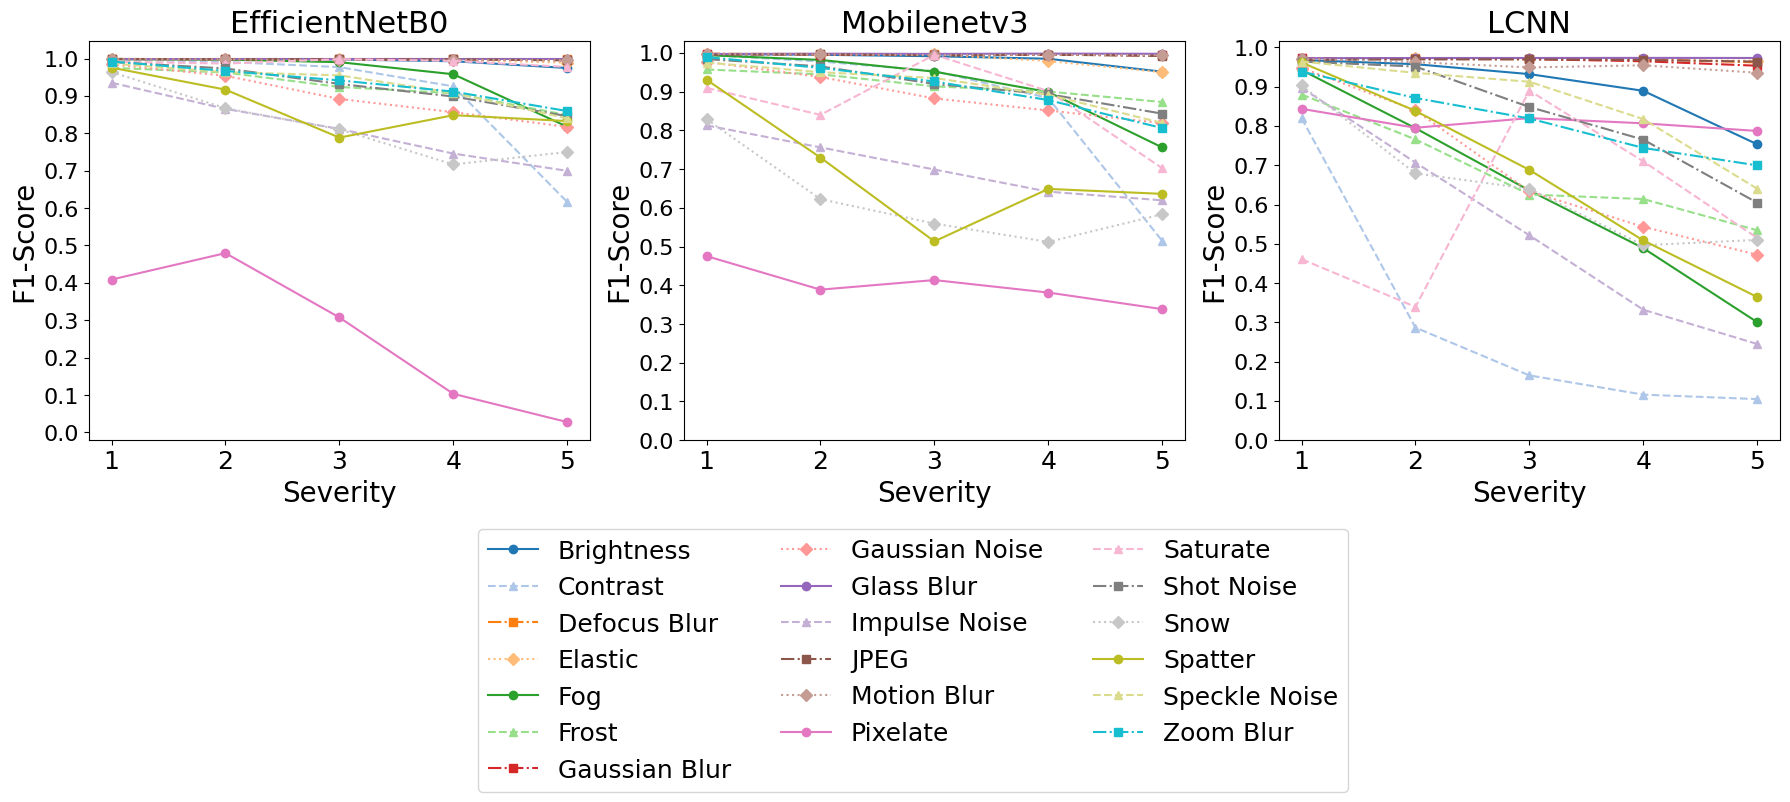

In [40]:
import pandas as pd
import matplotlib.pyplot as plt

# Caminhos dos arquivos .xlsx
caminhos_arquivos = [
    "results/results_corrupted_data_efficientNetB0.xlsx",
    "results/results_corrupted_data_mobilenetv3.xlsx",
    "results/results_corrupted_data_lcnn.xlsx",
]

# Nome das colunas que você deseja extrair
colunas_desejadas = ['f1-score', 'corruption']

# Criar uma figura com 3 subplots lado a lado
fig, axs = plt.subplots(1, 3, figsize=(18, 6))  # 1 linha, 3 colunas, tamanho total da figura 18x6

# Títulos personalizados para cada gráfico
titulos = ['EfficientNetB0', 'Mobilenetv3', 'LCNN']

# Função para processar e plotar os dados
def processar_e_plotar(df, ax, titulo):
    novodf = pd.DataFrame(columns=['corruption', 'severidade', 'f1-score'])

    # Iterar sobre as linhas do DataFrame
    for index, row in df.iterrows():
        string = row['corruption']
        parts = string.split()
        corrupcao = ''
        severidade = 0
        if len(parts) == 3:
            corrupcao = parts[0]
            severidade = int(parts[2])
        elif len(parts) == 4:
            corrupcao = parts[0] + " " + parts[1]
            severidade = int(parts[3])
        novodf.loc[index] = [corrupcao, severidade, row['f1-score']]

    cores = plt.cm.tab20.colors
    linestyles = ['-', '--', '-.', ':']
    markers = ['o', '^', 's', 'D']
    cor_mapping = {}
    cor_index = 0

    for i, (name, group) in enumerate(novodf.groupby('corruption')):
        group = group.sort_values(by='severidade')
        if name not in cor_mapping:
            cor_mapping[name] = cores[cor_index]
            cor_index = (cor_index + 1) % len(cores)
        linestyle = linestyles[i % len(linestyles)]
        marker = markers[i % len(markers)]
        ax.plot(group['severidade'], group['f1-score'], marker=marker, linestyle=linestyle, label=name, color=cor_mapping[name])

    # Aumentar o tamanho da fonte dos eixos e ticks
    ax.set_xlabel('Severity', fontsize=20)  # Increased from 18
    ax.set_ylabel('F1-Score', fontsize=20)  # Increased from 18
    ax.set_title(titulo, fontsize=22)      # Increased from 20
    ax.set_xticks([1, 2, 3, 4, 5])
    ax.set_yticks([0, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0])
    ax.tick_params(axis='x', labelsize=18)  # Increased from 16
    ax.tick_params(axis='y', labelsize=16)  # Increased from 14

# Loop para processar e plotar cada arquivo
for i, (caminho_arquivo, titulo) in enumerate(zip(caminhos_arquivos, titulos)):
    # Ler o arquivo Excel e selecionar as colunas desejadas
    df = pd.read_excel(caminho_arquivo, usecols=colunas_desejadas)
    
    # Processar e plotar no subplot correspondente
    processar_e_plotar(df, axs[i], titulo)  # Passar o título personalizado

# Criar uma única legenda para todos os gráficos
handles, labels = axs[0].get_legend_handles_labels()  # Coletar handles e labels do primeiro gráfico
fig.legend(handles, labels, 
           loc='lower center', 
           bbox_to_anchor=(0.51, -0.35), 
           ncol=3,
           fontsize=18)  # Legenda única mais embaixo

# Ajustar o layout para evitar sobreposição
plt.tight_layout(rect=[0, 0.12, 1, 1])  # Reserva espaço extra na parte de baixo

# Salvar o gráfico como uma imagem
caminho_salvar_imagem = r"C:\Users\saulo\PIBIC\artigo\resultados\vou-usar\grafico_f1-score_corrupcoes.png"
plt.savefig(caminho_salvar_imagem, bbox_inches='tight', dpi=300)  # Salvar em alta resolução (300 dpi)

# Mostrar o gráfico
plt.show()

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.table import Table

# Caminhos dos arquivos .xlsx
# caminhos_arquivos = [
#     r"C:/Users/DESKTOP/pesquisaGabriel/resultadosDasRedes/resultado_final_geral_bancosCorrompidos_ResNet50ModeloEscolhido.xlsx",
#     r"C:/Users/DESKTOP/pesquisaGabriel/resultadosDasRedes/resultado_final_geral_bancosCorrompidos_ResNet101ModeloEscolhido.xlsx",
#     r"C:/Users/DESKTOP/pesquisaGabriel/resultadosDasRedes/resultado_final_geral_bancosCorrompidos_Vgg16ModeloEscolhido.xlsx"
# ]


caminhos_arquivos = [
    "results/results_corrupted_data_efficientNetB0.xlsx",
    "results/results_corrupted_data_mobilenetv3.xlsx",
    "results/results_corrupted_data_lcnn.xlsx",
]


# Nome das colunas que você deseja extrair
colunas_desejadas = ['f1-score', 'corruption']

# Nomes dos modelos
# nomes_modelos = ['ResNet50', 'ResNet101', 'VGG16']
nomes_modelos = ['ResNet50', 'ResNet101', 'VGG16', 'LCNN', 'Xception']

# Função para processar os dados e calcular as médias
def processar_e_calcular_medias(df):
    novodf = pd.DataFrame(columns=['corruption', 'severidade', 'f1-score'])

    # Iterar sobre as linhas do DataFrame
    for index, row in df.iterrows():
        # String de exemplo
        string = row['corruption']
        # Dividir a string em uma lista de palavras
        parts = string.split()
        corrupcao = ''
        severidade = 0
        # Verificar se a lista tem exatamente 3 elementos
        if len(parts) == 3:
            corrupcao = parts[0]
            severidade = int(parts[2])  # Convertendo para inteiro
        elif len(parts) == 4:
            corrupcao = parts[0] + " " + parts[1]
            severidade = int(parts[3])  # Convertendo para inteiro
        
        novodf.loc[index] = [corrupcao, severidade, row['f1-score']]

    # Calcular a média do f1-score para cada corrupção
    medias = novodf.groupby('corruption')['f1-score'].mean().reset_index()
    medias = medias.sort_values(by='f1-score', ascending=False)

    return medias

# Lista para armazenar os resultados de cada modelo
resultados = []

# Loop para processar cada arquivo
for caminho_arquivo, nome_modelo in zip(caminhos_arquivos, nomes_modelos):
    # Ler o arquivo Excel e selecionar as colunas desejadas
    df = pd.read_excel(caminho_arquivo, usecols=colunas_desejadas)
    
    # Processar e calcular as médias
    medias = processar_e_calcular_medias(df)
    
    # Adicionar o nome do modelo ao DataFrame
    medias['Modelo'] = nome_modelo
    
    # Adicionar os resultados à lista
    resultados.append(medias)

# Concatenar todos os resultados em um único DataFrame
resultados_concatenados = pd.concat(resultados, ignore_index=True)

# Função para obter o top 3 e o bottom 3 de cada modelo
def obter_top_bottom_3(df):
    top3 = df.head(3).copy()  # Usar .copy() para evitar SettingWithCopyWarning
    bottom3 = df.tail(3).copy()  # Usar .copy() para evitar SettingWithCopyWarning
    
    # Adicionar coluna de posição
    top3['Posição'] = ['Top 1', 'Top 2', 'Top 3']
    bottom3['Posição'] = ['Bottom 1', 'Bottom 2', 'Bottom 3']
    
    return top3, bottom3

# Criar uma tabela final com o top 3 e o bottom 3 de cada modelo
tabela_final = pd.DataFrame()

for nome_modelo in nomes_modelos:
    df_modelo = resultados_concatenados[resultados_concatenados['Modelo'] == nome_modelo].copy()  # Usar .copy() para evitar SettingWithCopyWarning
    top3, bottom3 = obter_top_bottom_3(df_modelo)
    
    # Concatenar top 3 e bottom 3
    tabela_final = pd.concat([tabela_final, top3, bottom3], ignore_index=True)

# Reorganizar a tabela para o formato desejado
tabela_reorganizada = pd.DataFrame()

# Definir as linhas de ranqueamento
linhas_ranqueamento = ['Top 1', 'Top 2', 'Top 3', 'Bottom 1', 'Bottom 2', 'Bottom 3']

# Preencher a tabela reorganizada
for posicao in linhas_ranqueamento:
    dados_posicao = []
    for nome_modelo in nomes_modelos:
        # Filtrar os dados para a posição e modelo atual
        filtro = tabela_final[(tabela_final['Modelo'] == nome_modelo) & (tabela_final['Posição'] == posicao)]
        if not filtro.empty:
            dados_posicao.append(f"{filtro['corruption'].values[0]} ({filtro['f1-score'].values[0]:.4f})")
        else:
            dados_posicao.append("")  # Caso não haja dados
    tabela_reorganizada[posicao] = dados_posicao

# Definir os modelos como índice da tabela
tabela_reorganizada.index = nomes_modelos

# Transpor a tabela para que as redes sejam colunas e as posições sejam linhas
tabela_reorganizada = tabela_reorganizada.T

# Salvar a tabela em um arquivo Excel (opcional)
caminho_salvar_tabela_excel = r"C:/Users/DESKTOP/pesquisaGabriel/resultadosDasRedes/tabela_reorganizada_VALIDANDO.xlsx"
tabela_reorganizada.to_excel(caminho_salvar_tabela_excel)

# Criar uma figura para a tabela
# fig, ax = plt.subplots(figsize=(12, 6))  # Tamanho da figura
fig, ax = plt.subplots(figsize=(16, 6))  # Aumentei a largura de 12 para 16
ax.axis('off')  # Desativar eixos

# Criar a tabela usando matplotlib
tabela = ax.table(
    cellText=tabela_reorganizada.values,  # Dados da tabela
    rowLabels=tabela_reorganizada.index,  # Rótulos das linhas
    colLabels=tabela_reorganizada.columns,  # Rótulos das colunas
    cellLoc='center',  # Alinhamento do texto nas células
    loc='center',  # Posição da tabela na figura
    colColours=['#f7f7f7'] * len(tabela_reorganizada.columns)  # Cor de fundo do cabeçalho
)

# Ajustar o estilo da tabela
tabela.auto_set_font_size(False)  # Desativar ajuste automático do tamanho da fonte
tabela.set_fontsize(12)  # Definir tamanho da fonte
tabela.scale(1.2, 1.5)  # Escalar a tabela

# Adicionar cores para destacar o Top 3 e Bottom 3
for i in range(len(tabela_reorganizada)):
    if i < 3:  # Top 3
        for j in range(len(tabela_reorganizada.columns)):
            tabela[(i + 1, j)].set_facecolor('#d4f7d4')  # Verde claro
    else:  # Bottom 3
        for j in range(len(tabela_reorganizada.columns)):
            tabela[(i + 1, j)].set_facecolor('#f7d4d4')  # Vermelho claro

# Salvar a tabela como uma imagem PNG
caminho_salvar_imagem = r"C:/Users/DESKTOP/pesquisaGabriel/resultadosDasRedes/tabela_TOP3eBOTTOM3_VALIDANDO.png"
plt.savefig(caminho_salvar_imagem, bbox_inches='tight', dpi=300)  # Salvar em alta resolução (300 dpi)

# Mostrar a tabela (opcional)
plt.show()